In [118]:
# !pip list --format=freeze > requirements.txt

# Optiver Realized Volatility Prediction

Le but de ce problème est de prédire la volatilité de "stocks" financiers.

## Description du dataset

Le dataset est constitué de données financières et plus particulièrement de carnets d'ordres et de carnets de transactions effectuées.  
Ces deux "book" sont deux ensembles de fichiers séparés.

Chaque book est classé par stock qui représente un indice financier.  
Pour chaque stock nous avons plusieurs time_id.  
Celles ci font référence à une fenêtre de valeurs réelles de 20 min. Elles ne sont pas chronologiquement consécutives.

Dans chacune de ces fenêtres nous n'avons accès qu'aux premières 10 min de données et nous devons prédire la volatilité dans les 10 min suivantes.  
Nous avons cependant accès à la volatilité réalisée des 10 min suivante.  
Celle ci est donc une valeur unique associée à l'interval de temps et sera notre target.

<img src="./img/DataBucketing.webp" width="300px">  
</br></br>
Example et explication :
</br>
<img src="./img/Data_chart.png" width="600px"></br>
<img src="./img/Data_explainations.PNG" width="600px">

## Process machine learning

Il s'agit d'un problème de régression supervisé.

Dans un premier temps nous explorerons nos données.  
Puis nous Ferons du feature engineering sur nos dataset de book et trade.

Ensuite il s'agira de agréger nos données sur un seul dataframe avec une ligne par time_id.

<!-- partie sur la validation -->

# Librairies

In [2]:
%matplotlib inline
# generic libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from joblib import Parallel, delayed
import pickle
import time
import plotly.graph_objects as go

# machine learning
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import r2_score, make_scorer
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
import optuna
from xgboost import XGBRegressor

# path and files treatment
import glob
import os

# Variables

In [35]:
# env could be 'local' or 'kaggle'
env = 'local'

if env == 'local':
    data_folder = './data'
    output = './output/'
    if not(os.path.exists(output)):
        os.makedirs(output)

elif env == 'kaggle':
    data_folder = '../input/optiver-realized-volatility-prediction'
    output = './'
else:
    print('env var must be defined')

bk_train_fol = '/book_train.parquet/'
td_train_fol = '/trade_train.parquet/'
bk_test_fol = '/book_test.parquet/'
td_test_fol = '/trade_test.parquet/'

model_final = 'finalized_model.sav'

RANDOM_SEED = 42

# Remove non efficient cells to be faster
fast = True


# Exploration

## Functions

In [4]:
def add_wap(df, number=1, column_prefix='wap'):
    df[column_prefix + str(number)] = (
        df['bid_price'+ str(number)] * df['ask_size'+ str(number)] + df['ask_price'+ str(number)] * df['bid_size'+ str(number)]) / (
            df['ask_size'+ str(number)]+ df['bid_size'+ str(number)])

def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def load_df(df_folder, nb_stock_to_load=0, data_folder=data_folder):
    '''load a parquet 
    
    arguments
    ---------------
    data_folder (str)
    df_folder (str)
    nb_stock_to_load (int)
        number of subfolders to load
    '''
    stock_list = os.listdir(data_folder + df_folder)

    if nb_stock_to_load == 0:
        nb_stock_to_load = len(stock_list)
    nb_stock_to_load = min(nb_stock_to_load, len(stock_list))
    
    if nb_stock_to_load == 1:
        df = pd.read_parquet(data_folder + df_folder + '/stock_id=0')
        df['stock_id'] = 0
    else:
        ## depreciated
        # subset_paths = []
        # for stock in stock_list[:nb_stock_to_load]:
        #     subset_path = glob.glob(data_folder + df_folder + stock + '/*')
        #     subset_paths.append(subset_path[0])

        subset_paths = [glob.glob(data_folder + df_folder + stock + '/*')[0] for stock in stock_list[:nb_stock_to_load]]
        ## doesn't work
        # subset_paths = glob.glob(data_folder + df_folder + '/*')[:nb_stock_to_load]
        
        df = pd.read_parquet(subset_paths)
        df['stock_id'] = df['stock_id'].astype(int)
    return df

def rmspe(y_true, y_pred):
    return  (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true))))

## Book train 


In [37]:
book_train = load_df(bk_train_fol, nb_stock_to_load=1)
book_train.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,0
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,0
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,0
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,0


In [38]:
book_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 917553 entries, 0 to 917552
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   time_id            917553 non-null  int16  
 1   seconds_in_bucket  917553 non-null  int16  
 2   bid_price1         917553 non-null  float32
 3   ask_price1         917553 non-null  float32
 4   bid_price2         917553 non-null  float32
 5   ask_price2         917553 non-null  float32
 6   bid_size1          917553 non-null  int32  
 7   ask_size1          917553 non-null  int32  
 8   bid_size2          917553 non-null  int32  
 9   ask_size2          917553 non-null  int32  
 10  stock_id           917553 non-null  int64  
dtypes: float32(4), int16(2), int32(4), int64(1)
memory usage: 38.5 MB


### Sample

In [124]:
# Sample
book_train_sample = book_train[(book_train['stock_id'] == 0) & (book_train['time_id'] < 35)].copy()
add_wap(book_train_sample)
fig = px.line(book_train_sample, x="seconds_in_bucket", y="wap1", title='WAP of stock_id_0, time_id <35', color='time_id')
fig.show()

In [125]:
book_train_sample['log_return'] = book_train_sample.groupby(['time_id'])['wap1'].apply(log_return)
book_train_sample = book_train_sample[~book_train_sample['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

In [126]:
fig = px.line(book_train_sample, x="seconds_in_bucket", y="log_return", title='Log return of stock_id_0, time_id <35', color='time_id')
fig.show()

In [127]:
# Realized volatility on our sample
realized_vol = book_train_sample.groupby(['time_id'])['log_return'].agg(realized_volatility)
print('Realized volatility for stock_id 0 :')
for i in realized_vol.index:
    print(f'- time_id {i} is {round(realized_vol.loc[i], 7)}')

Realized volatility for stock_id 0 :
- time_id 5 is 0.0044994
- time_id 11 is 0.0012044
- time_id 16 is 0.0023685
- time_id 31 is 0.0025738


## Trade train 

In [128]:
# Test tp know if the book and trade data are on same stocks
os.listdir(data_folder + td_train_fol) == os.listdir(data_folder + bk_train_fol)

True

In [129]:
trade_train = load_df(td_train_fol, nb_stock_to_load=2)

In [130]:
trade_train.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,5,21,1.002301,326,12,0
1,5,46,1.002778,128,4,0
2,5,50,1.002818,55,1,0
3,5,57,1.003155,121,5,0
4,5,68,1.003646,4,1,0


### Sample

In [131]:
trade_train_sample = trade_train[(trade_train.stock_id == 0) & (trade_train.time_id < 35)]

fig = px.line(trade_train_sample, x="seconds_in_bucket", y="price", title='Price of stock_id_0, time_id <35', color='time_id')
fig.show()

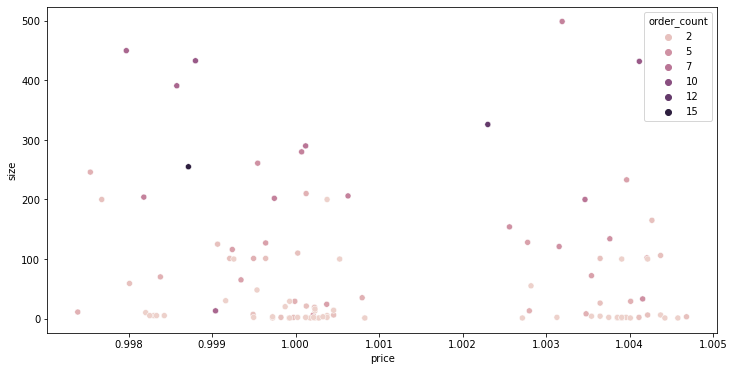

In [132]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=trade_train_sample, x="price", y="size", hue="order_count")

plt.show()

## Book/Trade test

These file are here just to show the shape and firsts value of the hidden 10 min window.

In [5]:
book_test = load_df(bk_test_fol)
book_test.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,stock_id
0,4,0,1.000049,1.000590,0.999656,1.000639,91,100,100,24,0
1,4,1,1.000049,1.000590,0.999656,1.000639,91,100,100,20,0
2,4,5,1.000049,1.000639,0.999656,1.000885,290,20,101,15,0


In [6]:
trade_test = load_df(td_test_fol)
trade_test.head()

,time_id,seconds_in_bucket,price,size,order_count,stock_id
0,4,7,1.000344,1,1,0
1,4,24,1.000049,100,7,0
2,4,27,1.000059,100,3,0


## Targets / realized volatility

In [7]:
vol_test = pd.read_csv(data_folder +'/test.csv')
vol_test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [8]:
vol_train = pd.read_csv(data_folder +'/train.csv')
vol_train.head()

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747


In [9]:
vol_train.shape

(428932, 3)

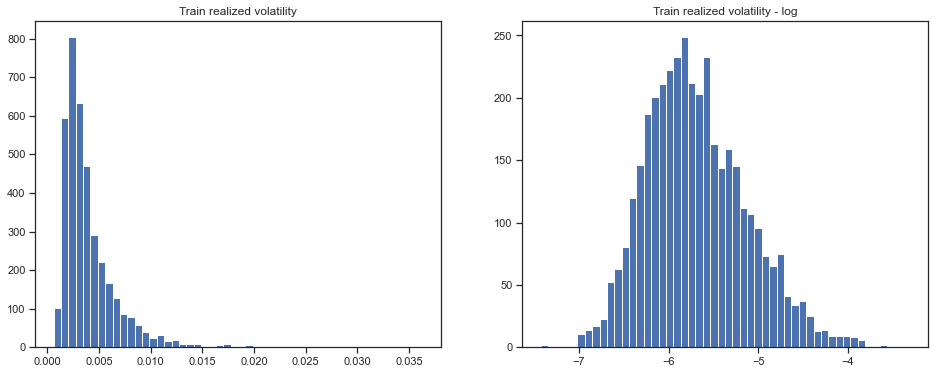

In [138]:
vol_stock0 = vol_train[vol_train['stock_id'] == 0]

sns.set_theme(style="ticks")
fig = plt.figure(figsize=(16, 6))
# fig.suptitle('Images after equalization preprocessing', fontsize=16)
# fig.tight_layout()

plt.subplot(1, 2, 1)
plt.title("Train realized volatility")
plt.hist(vol_stock0['target'], bins=50)

plt.subplot(1, 2, 2)
plt.title("Train realized volatility - log")
plt.hist(np.log(vol_stock0['target']), bins=50)

plt.show()

# Naive RMSE

A commonly known fact about volatility is that it tends to be autocorrelated. We can use this property to implement a naive model that just "predicts" realized volatility by using whatever the realized volatility was in the initial 10 minutes.

Let's calculate the past realized volatility across the training set to see how predictive a single naive signal can be.

In [139]:
# select all stocks books
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '/*')
list_order_book_file_train[:2] # example

['./data/book_train.parquet\\stock_id=0',
 './data/book_train.parquet\\stock_id=1']

In [6]:
def realized_volatility_per_time_id(file_path, prediction_column_name):
    '''load datas of one stock_id then calculate WAP, log_return
    set a new DF and put inside realized_volatility per time_id
    add a column with competition form : {stock_id}-{time_id} called row_id

    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0
    prediction_column_name : name of the realized_volatility column
    
    return row_id, prediction_name columns'''
    df_book_data = pd.read_parquet(file_path)
    add_wap(df_book_data)

    df_book_data['log_return'] = df_book_data.groupby(['time_id'])['wap1'].apply(log_return)
    df_book_data = df_book_data[~df_book_data['log_return'].isnull()] # removing each Nan of firsts time_id, ~ : invers the mask

    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['time_id'])['log_return'].agg(realized_volatility)).reset_index()
    df_realized_vol_per_stock = df_realized_vol_per_stock.rename(columns = {'log_return':prediction_column_name})
    
    stock_id = file_path.split('=')[1]
    df_realized_vol_per_stock['row_id'] = df_realized_vol_per_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    
    return df_realized_vol_per_stock[['row_id',prediction_column_name]]

In [5]:
def past_realized_volatility_per_stock(list_file,prediction_column_name):
    df_past_realized = pd.DataFrame()
    for file in list_file:
        df_past_realized = pd.concat([df_past_realized,
                                     realized_volatility_per_time_id(file,prediction_column_name)])
    return df_past_realized

# test on all 126 stocks 
# long ! 230 sec
df_past_realized_train = past_realized_volatility_per_stock(list_file=list_order_book_file_train,
                                                           prediction_column_name='pred')
df_past_realized_train.head()

NameError: name 'list_order_book_file_train' is not defined

In [142]:
df_naive = vol_train.copy()
# Let's join the output dataframe with train.csv to see the performance of the naive prediction on training set.
# naive prediction = predict same volatility in the next 10min window (auto realisation)
df_naive['row_id'] = df_naive['stock_id'].astype(str) + '-' + df_naive['time_id'].astype(str)
df_naive = df_naive[['row_id','target']]
df_naive = df_naive.merge(df_past_realized_train[['row_id','pred']], on = ['row_id'], how = 'left')

In [143]:
df_naive.head()

,row_id,target,pred
0,0-5,0.004136,0.004499
1,0-11,0.001445,0.001204
2,0-16,0.002168,0.002369
3,0-31,0.002195,0.002574
4,0-62,0.001747,0.001894


In [144]:
R2 = round(r2_score(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
RMSPE = round(rmspe(y_true = df_naive['target'], y_pred = df_naive['pred']),3)
print(f'Performance of the naive prediction: R2 score: {R2}, RMSPE: {RMSPE}')

Performance of the naive prediction: R2 score: 0.628, RMSPE: 0.341


# Preprocessing
---

## Improvements

add MAD var, std ?
exponential moving average : pandas.Series.ewm()

instead of dic, more explicit, list to pass to agg  
max_height=pd.NamedAgg(column='height', aggfunc='max'),  
min_weight=pd.NamedAgg(column='weight', aggfunc='min')

fill empty second_in_bucket in book data with the same as the last one
fill                            trade with 0 ?

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

In [43]:
number_of_stocks = 150

## Book train
---

In [44]:
list_order_book_file_train = glob.glob(data_folder + bk_train_fol + '*')[:number_of_stocks]

In [129]:
def add_waps(df):
        add_wap(df, 1, column_prefix='wap')
        add_wap(df, 2, column_prefix='wap')
        df['wap_p'] = ((
        df['wap1'] * (df['ask_size1'] + df['bid_size1']) +
        df['wap2'] * (df['ask_size2'] + df['bid_size2'])) /
        (df['ask_size1'] + df['bid_size1'] + df['ask_size2'] + df['bid_size2']))

def add_log_return(df, price_col, log_col_name, group='time_id'):
        df[log_col_name] = df.groupby([group])[price_col].apply(log_return)


# def add_balance_to_mean(df, price, bal_col_nam, group='time_id'):
#         df[bal_col_nam] = book_train[price] - book_train.groupby([group])[price].transform('mean')
def add_spreads(df):
    df['bid_spread_p'] = (df['bid_price1'] * df['bid_size1'] - df['bid_price2'] * df['bid_size1'])/(df['bid_size1'] + df['bid_size2'])
    df['ask_spread_p'] = (df['ask_price1'] * df['ask_size1'] - df['ask_price2'] * df['ask_size1'])/(df['ask_size1'] + df['ask_size2'])
    df["bid_ask_spread_p"] = abs(df['bid_spread_p'] - df['ask_spread_p'])

def add_volumes(df):
        df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
        df['volume_balance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

def add_EMA(df, wap_col, nb_period):
        df[wap_col + '_' + str(nb_period) + 'sec_EWM'] = df[wap_col].ewm(span=nb_period, adjust=False).mean()



In [160]:
waps = ['wap1', 'wap2', 'wap_p']
spreads = ['bid_spread_p', 'ask_spread_p', 'bid_ask_spread_p']

def book_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/book_train/stock_id=0

    return the df '''
    book_train = pd.read_parquet(file_path)

    add_waps(book_train)
    
    for wap in waps:
        add_log_return(book_train, price_col=wap, log_col_name=wap + '_log_return')
        for period in  [20, 100]:
            add_EMA(book_train, wap, period)
            EMA_col_name = wap + '_' + str(period) + 'sec_EWM'
            add_log_return(book_train, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
    
    add_spreads(book_train)
    add_volumes(book_train)


    # book_train = book_train[~(book_train['wap1_log_return'].isnull() | book_train['log_return2'].isnull() | book_train['log_return_p'].isnull())] # at the end ?
    book_train = book_train.fillna(book_train.median())
    
    return book_train

In [161]:
# sample with stock 0
df_sample = book_feature_eng_per_stock(list_order_book_file_train[0])

In [162]:
df_sample.head()

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2,...,wap_p_log_return,wap_p_20sec_EWM,wap_p_20sec_EWM_log_return,wap_p_100sec_EWM,wap_p_100sec_EWM_log_return,bid_spread_p,ask_spread_p,bid_ask_spread_p,total_volume,volume_balance
0,5,0,1.001422,1.002301,1.00137,1.002353,3,226,2,100,...,0.000000e+00,1.00142,3.900371e-07,1.00142,1.297746e-08,0.000031,-0.000036,0.000067,331,321
1,5,1,1.001422,1.002301,1.00137,1.002353,3,100,2,100,...,-1.250457e-06,1.00142,-1.190911e-07,1.00142,-2.476152e-08,0.000031,-0.000026,0.000057,205,195
2,5,5,1.001422,1.002301,1.00137,1.002405,3,100,2,100,...,5.040343e-07,1.00142,-5.974589e-08,1.00142,-1.429032e-08,0.000031,-0.000052,0.000083,205,195
3,5,6,1.001422,1.002301,1.00137,1.002405,3,126,2,100,...,3.130015e-07,1.00142,-2.424616e-08,1.00142,-7.809303e-09,0.000031,-0.000058,0.000089,231,221
4,5,7,1.001422,1.002301,1.00137,1.002405,3,126,2,100,...,0.000000e+00,1.00142,-2.193700e-08,1.00142,-7.654663e-09,0.000031,-0.000058,0.000089,231,221


In [169]:
# df_sample.columns

In [167]:
bk_feature_dic = {}
for wap in waps:
    bk_feature_dic[wap + '_log_return'] = [realized_volatility]
    bk_feature_dic[wap] = [np.mean, np.std, pd.Series.mad]
    for period in [20, 100]:
        bk_feature_dic[wap + '_' + str(period) + 'sec_EWM_log_return'] = [np.mean, realized_volatility]
for spread in spreads:
    bk_feature_dic[spread] = [np.sum, np.std, np.mean]
bk_feature_dic['total_volume'] = [np.sum, np.mean]
bk_feature_dic['volume_balance'] = [np.std, np.mean]

bk_feature_dic

{'wap1_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'wap1': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>,
  <function pandas.core.generic.NDFrame._add_numeric_operations.<locals>.mad(self, axis=None, skipna=None, level=None)>],
 'wap1_20sec_EWM_log_return': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function __main__.realized_volatility(series_log_return)>],
 'wap1_100sec_EWM_log_return': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function __main__.realized_volatility(series_log_return)>],
 'wap2_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'wap2': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>,
  <func

In [153]:
def book_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id and apply the feature dic
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = book_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(bk_feature_dic).reset_index())

    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [142]:
def agg_df_and_concatenate_parallel(paths_list, func):

    df_agg = Parallel(n_jobs=-1)(
        delayed(func)(file) 
        for file in paths_list)
    
    df_agg = pd.concat(df_agg, ignore_index = True)

    return df_agg

In [168]:
%%time
df_book_agg = agg_df_and_concatenate_parallel(list_order_book_file_train, book_agg_form_parallele)
df_book_agg.head()

Wall time: 9min 33s


,wap1_log_return_realized_volatility,wap1_mean,wap1_std,wap1_mad,wap1_20sec_EWM_log_return_mean,wap1_20sec_EWM_log_return_realized_volatility,wap1_100sec_EWM_log_return_mean,wap1_100sec_EWM_log_return_realized_volatility,wap2_log_return_realized_volatility,wap2_mean,...,ask_spread_p_std,ask_spread_p_mean,bid_ask_spread_p_sum,bid_ask_spread_p_std,bid_ask_spread_p_mean,total_volume_sum,total_volume_mean,volume_balance_std,volume_balance_mean,row_id
0,0.004499,1.003725,0.000693,0.000471,6.374861e-06,0.000702,0.000007,0.000277,0.006999,1.003661,...,0.000085,-0.000070,0.050018,0.000144,0.000166,97696,323.496689,107.260583,134.894040,0-5
1,0.001204,1.000239,0.000262,0.000189,-1.210833e-05,0.000721,-0.000015,0.000347,0.002476,1.000206,...,0.000060,-0.000056,0.024952,0.000104,0.000125,82290,411.450000,102.139758,142.050000,0-11
2,0.002369,0.999542,0.000864,0.000709,-1.471092e-05,0.000419,-0.000009,0.000181,0.004801,0.999680,...,0.000144,-0.000135,0.042001,0.000162,0.000223,78274,416.351064,108.891243,141.414894,0-16
3,0.002574,0.998832,0.000757,0.000577,1.793928e-07,0.000650,-0.000002,0.000149,0.003637,0.998633,...,0.000043,-0.000037,0.017037,0.000140,0.000142,52232,435.266667,121.533215,146.216667,0-31
4,0.001894,0.999619,0.000258,0.000218,7.456594e-06,0.000431,0.000005,0.000129,0.003257,0.999626,...,0.000055,-0.000058,0.029465,0.000112,0.000167,60407,343.221591,102.407501,123.846591,0-62


## Trades
---

In [205]:
list_order_trade_file_train = glob.glob(data_folder + td_train_fol + '*')[:number_of_stocks]

In [206]:
def add_amount(df):
    df['amount'] = df['price'] * df['size']

In [207]:
def trade_feature_eng_per_stock(file_path):
    ''' Load datas of one stock_id then adding features.
    Removing Nan rows of theses features
    
    file_path : path of subfolders with stock_id
        example : ./data/trade_train/stock_id=0

    return the df '''
    df = pd.read_parquet(file_path)
        


    add_log_return(df, price_col='price', log_col_name='td_log_return')

    add_amount(df)
    for period in  [20, 100]:
        add_EMA(df, 'amount', period)
        EMA_col_name = 'amount_' + str(period) + 'sec_EWM'
        add_log_return(df, price_col=EMA_col_name, log_col_name=EMA_col_name + '_log_return')
        
    df['diff_td'] = df.seconds_in_bucket.diff() # same Nan as log_return
    df['amount_p_order'] = df.amount / df.order_count

    df = df[~df['td_log_return'].isnull()] # at the end ?
    return df

In [208]:
# sample with stock 0
df_sample = trade_feature_eng_per_stock(list_order_trade_file_train[0])
df_sample.head()

,time_id,seconds_in_bucket,price,size,order_count,td_log_return,amount,amount_20sec_EWM,amount_20sec_EWM_log_return,amount_100sec_EWM,amount_100sec_EWM_log_return,diff_td,amount_p_order
1,5,46,1.002778,128,4,0.000476,128.355591,307.855507,-0.059566,322.821628,-0.012096,25.0,32.088898
2,5,50,1.002818,55,1,0.000040,55.155016,283.788794,-0.081400,317.521300,-0.016555,4.0,55.155016
3,5,57,1.003155,121,5,0.000336,121.381797,268.321461,-0.056045,313.637349,-0.012308,7.0,24.276359
4,5,68,1.003646,4,1,0.000489,4.014584,243.149377,-0.098510,307.506205,-0.019742,11.0,4.014584
5,5,78,1.003762,134,5,0.000116,134.504173,232.802215,-0.043487,304.080422,-0.011203,10.0,26.900835


In [9]:
# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

In [204]:
td_feature_dic = {}
for period in  [20, 100]:
    EMA_col_name = 'amount_' + str(period) + 'sec_EWM_log_return'
    td_feature_dic[EMA_col_name] = [realized_volatility]
td_feature_dic['td_log_return'] = [realized_volatility]
td_feature_dic['seconds_in_bucket'] = [count_unique]
td_feature_dic['diff_td'] = [np.mean, np.std]
td_feature_dic['amount_p_order'] = [np.mean, np.sum]
td_feature_dic['price'] = [np.mean, np.std, pd.Series.mad]
td_feature_dic['amount'] = [np.mean, np.std, pd.Series.mad]
td_feature_dic['amount_p_order'] = [np.mean, np.sum]
td_feature_dic['size'] = [np.mean, np.sum]
td_feature_dic['order_count'] = [np.mean, np.sum]

td_feature_dic

{'amount_20sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'amount_100sec_EWM_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'td_log_return': [<function __main__.realized_volatility(series_log_return)>],
 'seconds_in_bucket': [<function __main__.count_unique(series)>],
 'diff_td': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>],
 'amount_p_order': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.sum(a, axis=None, dtype=None, out=None, keepdims=<no value>, initial=<no value>, where=<no value>)>],
 'price': [<function numpy.mean(a, axis=None, dtype=None, out=None, keepdims=<no value>)>,
  <function numpy.std(a, axis=None, dtype=None, out=None, ddof=0, keepdims=<no value>)>,
  <function pandas.core.generic.NDFrame._add_numeric_operations.<locals>.mad(self,

In [203]:
def trade_agg_form_parallele(file):
    ''' Create a new df that aggregate data by time_id
    add :
    - a stock_id columns
    - a with competition form column : {stock_id}-{time_id} called row_id
    return the new df
    '''
    stock_id = file.split('=')[1]
    df_agg_stock = trade_feature_eng_per_stock(file)
    df_agg_stock = pd.DataFrame(df_agg_stock.groupby(['time_id']).agg(td_feature_dic)).reset_index()
    
    df_agg_stock.columns = ['_'.join(col).rstrip('_') for col in df_agg_stock.columns.values]
    df_agg_stock['row_id'] = df_agg_stock['time_id'].apply(lambda x:f'{stock_id}-{x}')
    # df_agg_stock['stock_id'] = stock_id
    df_agg_stock.drop('time_id', axis=1, inplace=True)

    return df_agg_stock

In [209]:
%%time
df_trade_agg = agg_df_and_concatenate_parallel(list_order_trade_file_train, trade_agg_form_parallele)
df_trade_agg.head()

Wall time: 3min 2s


,amount_20sec_EWM_log_return_realized_volatility,amount_100sec_EWM_log_return_realized_volatility,td_log_return_realized_volatility,seconds_in_bucket_count_unique,diff_td_mean,diff_td_std,amount_p_order_mean,amount_p_order_sum,price_mean,price_std,price_mad,amount_mean,amount_std,amount_mad,size_mean,size_sum,order_count_mean,order_count_sum,row_id
0,0.810606,0.107992,0.002006,39,14.461538,12.661267,23.100317,900.912351,1.003759,0.000537,0.000425,73.420229,113.282652,79.821339,73.153846,2853,2.512821,98.0,0-5
1,0.960455,0.095978,0.000901,29,19.551723,14.681344,20.724629,601.014231,1.000219,0.000300,0.000232,44.391510,78.820060,57.928094,44.379310,1287,1.896552,55.0,0-11
2,0.758793,0.099807,0.001961,24,22.500000,19.381748,26.498888,635.973322,0.999162,0.000928,0.000774,89.858687,114.491758,93.426704,89.958333,2159,2.791667,67.0,0-16
3,0.479299,0.095522,0.001561,14,40.928570,32.636611,34.936621,489.112699,0.998933,0.000671,0.000556,139.043038,146.206953,111.716741,139.214286,1949,4.142857,58.0,0-31
4,0.538092,0.100346,0.000871,21,27.047619,17.502789,16.893227,354.757776,0.999599,0.000162,0.000125,85.202594,119.362773,98.158010,85.238095,1790,4.190476,88.0,0-62


## Final DF
---

In [217]:
stock_id_max = max([int(path.split('=')[1]) for path in list_order_trade_file_train]) # files on kaggle are random sorted

df = vol_train[vol_train.stock_id <= stock_id_max].copy()
df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

df = df.merge(df_book_agg, on = ['row_id'], how = 'left')
df = df.merge(df_trade_agg, on = ['row_id'], how = 'left')

df.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,wap1_mean,wap1_std,wap1_mad,wap1_20sec_EWM_log_return_mean,wap1_20sec_EWM_log_return_realized_volatility,...,price_mean,price_std,price_mad,amount_mean,amount_std,amount_mad,size_mean,size_sum,order_count_mean,order_count_sum
0,0,5,0.004136,0-5,0.004499,1.003725,0.000693,0.000471,6.374861e-06,0.000702,...,1.003759,0.000537,0.000425,73.420229,113.282652,79.821339,73.153846,2853.0,2.512821,98.0
1,0,11,0.001445,0-11,0.001204,1.000239,0.000262,0.000189,-1.210833e-05,0.000721,...,1.000219,0.000300,0.000232,44.391510,78.820060,57.928094,44.379310,1287.0,1.896552,55.0
2,0,16,0.002168,0-16,0.002369,0.999542,0.000864,0.000709,-1.471092e-05,0.000419,...,0.999162,0.000928,0.000774,89.858687,114.491758,93.426704,89.958333,2159.0,2.791667,67.0
3,0,31,0.002195,0-31,0.002574,0.998832,0.000757,0.000577,1.793928e-07,0.000650,...,0.998933,0.000671,0.000556,139.043038,146.206953,111.716741,139.214286,1949.0,4.142857,58.0
4,0,62,0.001747,0-62,0.001894,0.999619,0.000258,0.000218,7.456594e-06,0.000431,...,0.999599,0.000162,0.000125,85.202594,119.362773,98.158010,85.238095,1790.0,4.190476,88.0


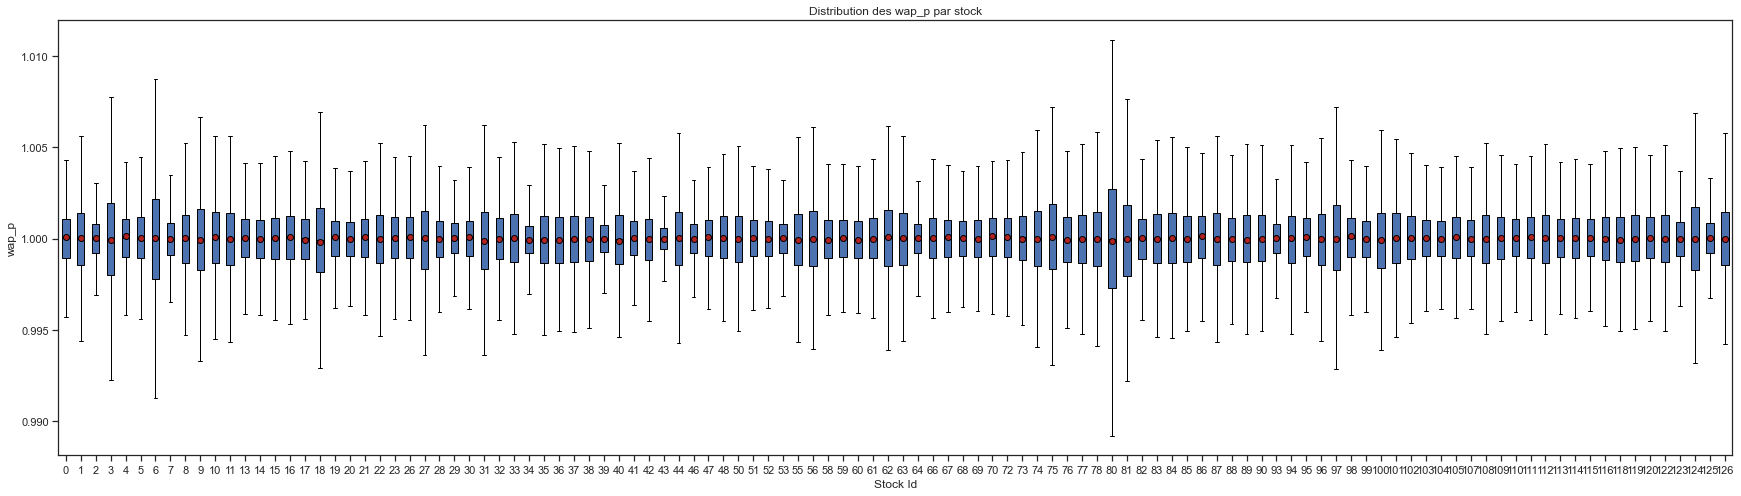

In [164]:
#Création d'un sous échantillon par modalité
groupes = []
for s in df['stock_id'].unique():
    groupes.append(df[df['stock_id'] == s]['wap_p_mean'])
 
# 'OO' méthode pour plot
fig, ax = plt.subplots(figsize=(30,8))

# Propriétés graphiques
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

ax.boxplot(groupes,
           labels=df['stock_id'].unique(),
           showfliers=False,
           medianprops=medianprops, 
           vert=True,
           patch_artist=True,
           showmeans=True,
           meanprops=meanprops)

ax.set(title='Distribution des wap_p par stock',
      xlabel="Stock Id",
      ylabel='wap_p')

plt.show()

In [219]:
df.to_pickle(output + 'dataset_train.pkl')

In [222]:
df.to_pickle(output + 'dataset_train.bz2', compression='bz2')

# Machine learning
---

In [10]:
df = pd.read_pickle(output + 'dataset_train.pkl')

In [11]:
df.head()

,stock_id,time_id,target,row_id,wap1_log_return_realized_volatility,wap1_mean,wap1_std,wap1_mad,wap1_20sec_EWM_log_return_mean,wap1_20sec_EWM_log_return_realized_volatility,...,price_mean,price_std,price_mad,amount_mean,amount_std,amount_mad,size_mean,size_sum,order_count_mean,order_count_sum
0,0,5,0.004136,0-5,0.004499,1.003725,0.000693,0.000471,6.374861e-06,0.000702,...,1.003759,0.000537,0.000425,73.420229,113.282652,79.821339,73.153846,2853.0,2.512821,98.0
1,0,11,0.001445,0-11,0.001204,1.000239,0.000262,0.000189,-1.210833e-05,0.000721,...,1.000219,0.000300,0.000232,44.391510,78.820060,57.928094,44.379310,1287.0,1.896552,55.0
2,0,16,0.002168,0-16,0.002369,0.999542,0.000864,0.000709,-1.471092e-05,0.000419,...,0.999162,0.000928,0.000774,89.858687,114.491758,93.426704,89.958333,2159.0,2.791667,67.0
3,0,31,0.002195,0-31,0.002574,0.998832,0.000757,0.000577,1.793928e-07,0.000650,...,0.998933,0.000671,0.000556,139.043038,146.206953,111.716741,139.214286,1949.0,4.142857,58.0
4,0,62,0.001747,0-62,0.001894,0.999619,0.000258,0.000218,7.456594e-06,0.000431,...,0.999599,0.000162,0.000125,85.202594,119.362773,98.158010,85.238095,1790.0,4.190476,88.0


In [12]:
df.isnull().sum()

stock_id                                              0
time_id                                               0
target                                                0
row_id                                                0
wap1_log_return_realized_volatility                   0
wap1_mean                                             0
wap1_std                                              0
wap1_mad                                              0
wap1_20sec_EWM_log_return_mean                        0
wap1_20sec_EWM_log_return_realized_volatility         0
wap1_100sec_EWM_log_return_mean                       0
wap1_100sec_EWM_log_return_realized_volatility        0
wap2_log_return_realized_volatility                   0
wap2_mean                                             0
wap2_std                                              0
wap2_mad                                              0
wap2_20sec_EWM_log_return_mean                        0
wap2_20sec_EWM_log_return_realized_volatility   

In [13]:
df.fillna(0, inplace=True)
df.isnull().sum().sum()

0

In [14]:
X = df.drop(['row_id', 'target'], axis = 1)
X_val = X.values
y = df['target']
y_val = y.values

X.shape, y.shape

((428932, 57), (428932,))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=False)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364592, 57), (64340, 57), (364592,), (64340,))

In [16]:
n_trials = 50

In [17]:
## If I want to change the dic form :
# dic_eval = dict.fromkeys(['names', 'models', 'rmspe_scores', 'r2_scores'])
# dic_eval

In [18]:
dic_eval = {}
def evaluate(name, model, dic, X_test=X_test, y_test=y_test):
    y_pred = model.predict(X_test)
    R2 = round(r2_score(y_test, y_pred), 6)
    RMSPE = round(rmspe(y_test, y_pred), 6)
    dic[name] = [model, RMSPE, R2]
    print(f'Performance of the {name} prediction: R2 score: {R2}, RMSPE: {RMSPE}')

## KNN regression

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline



In [173]:
# pip_knn = make_pipeline(StandardScaler(),
#                           KNeighborsRegressor())

## LSTM Regression (1.ipynb)

In [174]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold

## Ridge 

In [27]:
scorer_rmspe = make_scorer(rmspe,
    # greater_is_better=False
    )

In [28]:
kfolds = KFold(n_splits=6, shuffle=True, random_state=RANDOM_SEED)

In [29]:
def tune(objective, n_trials=n_trials):
    start_time = time.time()
    study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
    study.optimize(objective, n_trials=n_trials, gc_after_trial=True)

    params = study.best_params
    print("--- %s seconds ---" % (time.time() - start_time))
    return params

In [30]:
def ridge_objective(trial):

    _alpha = trial.suggest_float("alpha", 0.1, 20)

    model_ridge = Ridge(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        model_ridge, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [31]:
ridge_params = tune(ridge_objective)
ridge_opt = Ridge(**ridge_params, random_state=RANDOM_SEED)

[I 2021-09-19 20:15:34,797] A new study created in memory with name: no-name-fa92b0fd-e07d-4fb8-bad6-87e611165bab
C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.41815e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.43697e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.53947e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=4.62e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
C

--- 104.07295751571655 seconds ---


In [32]:
ridge_opt.fit(X_train, y_train)
evaluate('Ridge', ridge_opt, dic_eval)

Performance of the Ridge prediction: R2 score: 0.766319, RMSPE: 0.300792


C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.78139e-21): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


## Lasso

In [33]:
def lasso_objective(trial):
    _alpha = trial.suggest_loguniform("alpha", 0.0001, 10)
    lasso = Lasso(alpha=_alpha, random_state=RANDOM_SEED)

    score = cross_val_score(
        lasso, X_train, y_train, cv=kfolds, scoring=scorer_rmspe
    ).mean()
    return score

In [36]:
if not(fast):
    lasso_params = tune(lasso_objective, n_trials=5) # long and results are bad
    lasso_opt = Lasso(**lasso_params, random_state=RANDOM_SEED)

In [183]:
if not(fast):
    lasso_opt.fit(X_train, y_train)
    evaluate('Lasso', lasso_opt, dic_eval)

Performance of the Lasso prediction: R2 score: 0.00375, RMSPE: 0.967573


C:\Users\Admin\miniconda3\envs\env_p8\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.1989889293018812, tolerance: 0.0003227512548833912



## RandomForrest

In [37]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 50, 200)
    _max_depth = trial.suggest_int("max_depth", 5, 20)
    _min_samp_split = trial.suggest_int("min_samples_split", 2, 10)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 2, 10)

    rf = RandomForestRegressor(
        max_depth=_max_depth,
        min_samples_split=_min_samp_split,
        min_samples_leaf=_min_samples_leaf,
        n_estimators=_n_estimators,
        n_jobs=-1,
        random_state=RANDOM_SEED,
    )

    rf.fit(X_train, y_train)

    preds = rf.predict(X_test)
    return rmspe(y_test, preds)

In [39]:
if not(fast):
    randomforest_params = tune(randomforest_objective, n_trials=5) # long, average results...
    rf_opt = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED, **randomforest_params)

In [186]:
if not(fast):
    rf_opt.fit(X_train, y_train)
    evaluate('RandomForrest', rf_opt, dic_eval)

Performance of the RandomForrest prediction: R2 score: 0.806049, RMSPE: 0.276401


## Basic XGB model

In [229]:

def plot_feature_importance(df, model):
    feature_importances_df = pd.DataFrame({
        'feature': df.columns,
        'importance_score': model.feature_importances_
    })
    fig = plt.figure(figsize=(20, 5))
    ax = sns.barplot(x = "feature", y = "importance_score", data = feature_importances_df)
    ax.set(xlabel="Features", ylabel = "Importance Score")
    # plt.xticks(ha='left', rotation=45)
    fig.autofmt_xdate(bottom=0.2, rotation=30, ha='right')
    plt.show()
    # return feature_importances_df

In [230]:
if env == 'kaggle':
    xgb = XGBRegressor(tree_method='gpu_hist', random_state=42, n_jobs= - 1)
else:
    xgb = XGBRegressor(tree_method='hist', random_state=42, n_jobs= - 1)



In [231]:
%%time
xgb.fit(X_train, y_train)

Wall time: 6.85 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='hist', validate_parameters=1, verbosity=None)

In [237]:
evaluate('XGBOOST', xgb, dic_eval)

Performance of the XGBOOST prediction: R2 score: 0.769402, RMSPE: 0.308532


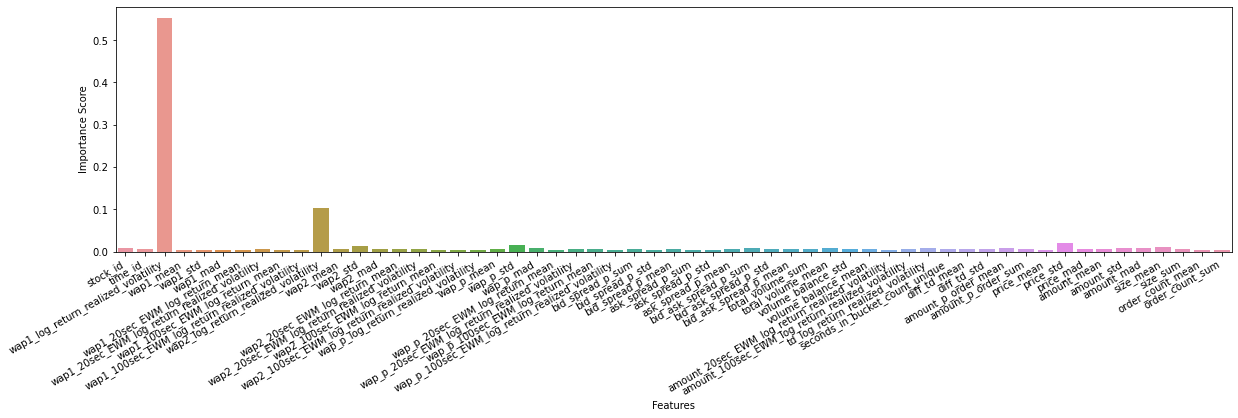

In [238]:
plot_feature_importance(X, xgb)

## Basic LGBMRegressor model

In [239]:
if env == 'kaggle':
    lgbm = LGBMRegressor(device='gpu', random_state=42)
else:
    lgbm = LGBMRegressor(device='cpu', random_state=42)


In [240]:
%%time
lgbm.fit(X_train, y_train)

Wall time: 4.18 s


LGBMRegressor(device='cpu', random_state=42)

In [241]:
evaluate('LIGHTGBM', lgbm, dic_eval)

Performance of the LIGHTGBM prediction: R2 score: 0.794423, RMSPE: 0.261368


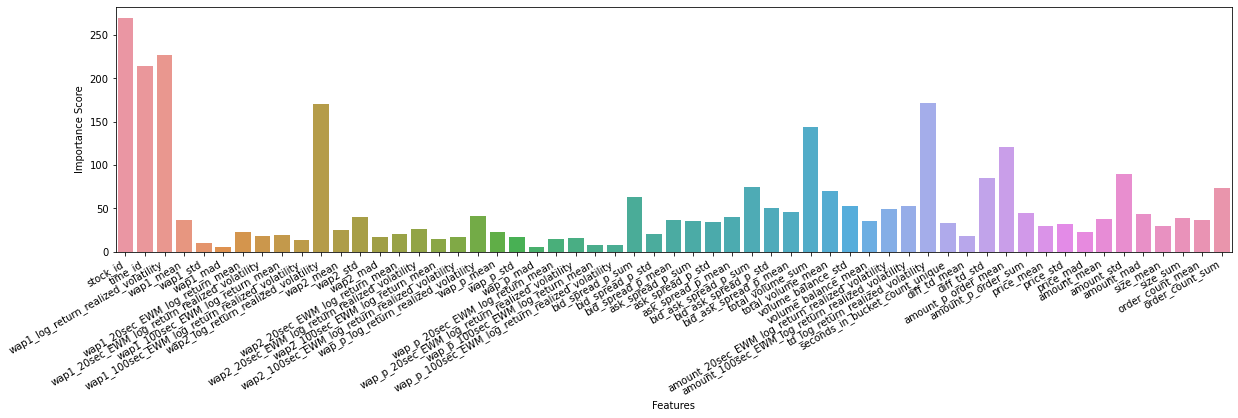

In [242]:
plot_feature_importance(X, lgbm)

## Optuna Tuned XGBoost

Optuna va nous permettre de trouver nos meilleurs hyperparamètres.  
Il suffira ensuite d'entraîner notre modèle avec ces paramètres pour l'évaluer.

In [243]:
def objective_xgb(trial):

    param = {'tree_method':'gpu_hist', 
            'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
            'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
            'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
            'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
            'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
            'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
            'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300)}

    if env == 'kaggle':
        param['tree_method'] = 'gpu_hist'
    else:
        param['tree_method'] = 'hist'
    
    model = XGBRegressor(**param, random_state=42)
    
    # pruning_callback = optuna.integration.XGBoostPruningCallback(trial, "validation-rmse")
    model.fit(X_train , y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)
    
    preds = model.predict(X_test)
    
    return rmspe(y_test, preds)

In [244]:
%%time
study_xgb = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_xgb.optimize(objective_xgb, n_trials=n_trials, gc_after_trial=True)

[I 2021-09-19 16:48:34,199] A new study created in memory with name: no-name-74124e58-e34b-4169-b20c-12c6748f8414
[I 2021-09-19 16:49:35,605] Trial 0 finished with value: 0.321195216997946 and parameters: {'lambda': 0.0010001877211913103, 'alpha': 8.727597882058513, 'colsample_bytree': 0.7, 'subsample': 0.7, 'learning_rate': 0.008, 'n_estimators': 2565, 'max_depth': 15, 'min_child_weight': 61}. Best is trial 0 with value: 0.321195216997946.
[I 2021-09-19 16:51:36,023] Trial 1 finished with value: 0.3081440104850402 and parameters: {'lambda': 0.016580306336832887, 'alpha': 0.0013211035815118711, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.008, 'n_estimators': 1001, 'max_depth': 15, 'min_child_weight': 33}. Best is trial 1 with value: 0.3081440104850402.
[I 2021-09-19 16:52:37,703] Trial 2 finished with value: 0.2623272633795329 and parameters: {'lambda': 0.008089097418221518, 'alpha': 0.08626639784302045, 'colsample_bytree': 0.4, 'subsample': 0.8, 'learning_rate': 0.01

Wall time: 1h 3min 35s


In [245]:
print('Number of finished trials:', len(study_xgb.trials))
print('Best trial:', study_xgb.best_trial.params)

Number of finished trials: 50
Best trial: {'lambda': 0.050695864818244944, 'alpha': 0.23319827340456734, 'colsample_bytree': 0.5, 'subsample': 0.8, 'learning_rate': 0.02, 'n_estimators': 1590, 'max_depth': 9, 'min_child_weight': 218}


In [246]:
optuna.visualization.plot_optimization_history(study_xgb)

In [247]:
optuna.visualization.plot_param_importances(study_xgb)

In [248]:
best_xgbparams = study_xgb.best_params
best_xgbparams

{'lambda': 0.050695864818244944,
 'alpha': 0.23319827340456734,
 'colsample_bytree': 0.5,
 'subsample': 0.8,
 'learning_rate': 0.02,
 'n_estimators': 1590,
 'max_depth': 9,
 'min_child_weight': 218}

In [20]:
# best_xgbparams = {'lambda': 0.050695864818244944,
#  'alpha': 0.23319827340456734,
#  'colsample_bytree': 0.5,
#  'subsample': 0.8,
#  'learning_rate': 0.02,
#  'n_estimators': 1590,
#  'max_depth': 9,
#  'min_child_weight': 218}

if env == 'Kaggle':
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='gpu_hist')
else:
    xgb_opt = XGBRegressor(**best_xgbparams, tree_method='hist', n_jobs= - 1)

In [21]:
%%time
xgb_opt.fit(X_train ,y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=100, verbose=False)

evaluate('XGB_opt', xgb_opt, dic_eval)

Performance of the XGB_opt prediction: R2 score: 0.802028, RMSPE: 0.259347
Wall time: 1min 8s


## Optuna Tuned LGBM

In [251]:
def objective_lgbm(trial):
        param = {"device": "gpu",
                "metric": "rmse",
                "verbosity": -1,
                'learning_rate':trial.suggest_loguniform('learning_rate', 0.005, 0.5),
                "max_depth": trial.suggest_int("max_depth", 2, 500),
                "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
                "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
                "num_leaves": trial.suggest_int("num_leaves", 2, 256),
                "n_estimators": trial.suggest_int("n_estimators", 100, 4000),
        #         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 100000, 700000),
                "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
                "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
                "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
                "min_child_samples": trial.suggest_int("min_child_samples", 5, 100)}

        if env == 'kaggle':
                param["device"] = "gpu"
        else:
                param["device"] = "cpu"

        pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
        model = LGBMRegressor(**param)

        model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        preds = model.predict(X_test)
        return rmspe(y_test, preds)

In [252]:
%%time
study_lgbm = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study_lgbm.optimize(objective_lgbm, n_trials=n_trials, gc_after_trial=True) # n_jobs=-1 make the calcul longer !

[I 2021-09-19 18:33:41,138] A new study created in memory with name: no-name-bdec73cd-e63d-423f-bb86-225fd05fff1a


[LightGBM] [Warning] feature_fraction is set=0.6744552501464487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744552501464487
[LightGBM] [Warning] lambda_l1 is set=0.0911256640760148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0911256640760148
[LightGBM] [Warning] bagging_fraction is set=0.7249343934370382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7249343934370382
[LightGBM] [Warning] lambda_l2 is set=7.619751773104654e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619751773104654e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-09-19 18:34:50,948] Trial 0 finished with value: 0.2564778026085848 and parameters: {'learning_rate': 0.012206112226610026, 'max_depth': 176, 'lambda_l1': 0.0911256640760148, 'lambda_l2': 7.619751773104654e-07, 'num_leaves': 87, 'n_estimators': 2713, 'feature_fraction': 0.6744552501464487, 'bagging_fraction': 0.7249343934370382, 'bagging_freq': 7, 'min_child_samples': 53}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.9116410959027951, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9116410959027951
[LightGBM] [Warning] lambda_l1 is set=0.044204484289258134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.044204484289258134
[LightGBM] [Warning] bagging_fraction is set=0.8455956119562738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8455956119562738
[LightGBM] [Warning] lambda_l2 is set=4.7407963970713686e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.7407963970713686e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-09-19 18:35:14,854] Trial 1 finished with value: 0.25887635709063195 and parameters: {'learning_rate': 0.09367181374534725, 'max_depth': 248, 'lambda_l1': 0.044204484289258134, 'lambda_l2': 4.7407963970713686e-05, 'num_leaves': 40, 'n_estimators': 1028, 'feature_fraction': 0.9116410959027951, 'bagging_fraction': 0.8455956119562738, 'bagging_freq': 3, 'min_child_samples': 9}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.614718565035578, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.614718565035578
[LightGBM] [Warning] lambda_l1 is set=0.24143148916711502, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.24143148916711502
[LightGBM] [Warning] bagging_fraction is set=0.5758119255832665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5758119255832665
[LightGBM] [Warning] lambda_l2 is set=1.233896181103035e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.233896181103035e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-19 18:36:23,142] Trial 2 finished with value: 0.2598205012333106 and parameters: {'learning_rate': 0.023191629985719206, 'max_depth': 314, 'lambda_l1': 0.24143148916711502, 'lambda_l2': 1.233896181103035e-07, 'num_leaves': 256, 'n_estimators': 2576, 'feature_fraction': 0.614718565035578, 'bagging_fraction': 0.5758119255832665, 'bagging_freq': 5, 'min_child_samples': 65}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.5624117032438277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5624117032438277
[LightGBM] [Warning] lambda_l1 is set=1.1306812397355018e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1306812397355018e-06
[LightGBM] [Warning] bagging_fraction is set=0.5639863983007447, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5639863983007447
[LightGBM] [Warning] lambda_l2 is set=0.005226782805447696, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005226782805447696
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-09-19 18:36:34,497] Trial 3 finished with value: 0.2596132052154363 and parameters: {'learning_rate': 0.055423982213633184, 'max_depth': 347, 'lambda_l1': 1.1306812397355018e-06, 'lambda_l2': 0.005226782805447696, 'num_leaves': 159, 'n_estimators': 1027, 'feature_fraction': 0.5624117032438277, 'bagging_fraction': 0.5639863983007447, 'bagging_freq': 6, 'min_child_samples': 99}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.7344123720639562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7344123720639562
[LightGBM] [Warning] lambda_l1 is set=8.933350990307223e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.933350990307223e-06
[LightGBM] [Warning] bagging_fraction is set=0.8140407929414455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8140407929414455
[LightGBM] [Warning] lambda_l2 is set=0.0009701876229048742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009701876229048742
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-09-19 18:36:42,281] Trial 4 finished with value: 0.2586298875285708 and parameters: {'learning_rate': 0.2040621379350633, 'max_depth': 119, 'lambda_l1': 8.933350990307223e-06, 'lambda_l2': 0.0009701876229048742, 'num_leaves': 91, 'n_estimators': 1193, 'feature_fraction': 0.7344123720639562, 'bagging_fraction': 0.8140407929414455, 'bagging_freq': 1, 'min_child_samples': 44}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.976994200058699, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.976994200058699
[LightGBM] [Warning] lambda_l1 is set=0.3824966225905511, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3824966225905511
[LightGBM] [Warning] bagging_fraction is set=0.49752514988910895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49752514988910895
[LightGBM] [Warning] lambda_l2 is set=0.5656944423005594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5656944423005594
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-09-19 18:36:44,115] Trial 5 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:36:46,832] Trial 6 pruned. Trial was pruned at iteration 40.
[I 2021-09-19 18:36:49,356] Trial 7 pruned. Trial was pruned at iteration 42.
[I 2021-09-19 18:36:55,026] Trial 8 pruned. Trial was pruned at iteration 59.
[I 2021-09-19 18:36:59,125] Trial 9 pruned. Trial was pruned at iteration 44.
[I 2021-09-19 18:37:01,081] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:37:03,364] Trial 11 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:37:06,913] Trial 12 pruned. Trial was pruned at iteration 42.
[I 2021-09-19 18:37:12,349] Trial 13 pruned. Trial was pruned at iteration 110.
[I 2021-09-19 18:37:14,327] Trial 14 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:37:16,180] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:37:18,170] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:37:22,265] Trial 17 pruned. Trial was pruned 

[LightGBM] [Warning] feature_fraction is set=0.5936604434857293, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5936604434857293
[LightGBM] [Warning] lambda_l1 is set=4.587396391602809e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.587396391602809e-06
[LightGBM] [Warning] bagging_fraction is set=0.6240956874117004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6240956874117004
[LightGBM] [Warning] lambda_l2 is set=0.22857112141688238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22857112141688238
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-09-19 18:38:17,554] Trial 34 pruned. Trial was pruned at iteration 79.
[I 2021-09-19 18:38:26,482] Trial 35 finished with value: 0.25831491187070416 and parameters: {'learning_rate': 0.0821990537330502, 'max_depth': 237, 'lambda_l1': 1.715016799872161e-07, 'lambda_l2': 3.823830123255235, 'num_leaves': 116, 'n_estimators': 407, 'feature_fraction': 0.5375647358967601, 'bagging_fraction': 0.7423978911002662, 'bagging_freq': 5, 'min_child_samples': 13}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.4627216643697131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4627216643697131
[LightGBM] [Warning] lambda_l1 is set=1.0702708738055572e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0702708738055572e-07
[LightGBM] [Warning] bagging_fraction is set=0.7638095039212032, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7638095039212032
[LightGBM] [Warning] lambda_l2 is set=4.754177882078937, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.754177882078937
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-19 18:38:34,572] Trial 36 finished with value: 0.258171890038942 and parameters: {'learning_rate': 0.1272838384064791, 'max_depth': 235, 'lambda_l1': 1.0702708738055572e-07, 'lambda_l2': 4.754177882078937, 'num_leaves': 133, 'n_estimators': 414, 'feature_fraction': 0.4627216643697131, 'bagging_fraction': 0.7638095039212032, 'bagging_freq': 5, 'min_child_samples': 17}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.4335277174296365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4335277174296365
[LightGBM] [Warning] lambda_l1 is set=1.1210367038973282e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1210367038973282e-08
[LightGBM] [Warning] bagging_fraction is set=0.7585445877416133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7585445877416133
[LightGBM] [Warning] lambda_l2 is set=4.092209610364272, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.092209610364272
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-19 18:38:41,781] Trial 37 finished with value: 0.25964796442096855 and parameters: {'learning_rate': 0.13940475817312334, 'max_depth': 247, 'lambda_l1': 1.1210367038973282e-08, 'lambda_l2': 4.092209610364272, 'num_leaves': 136, 'n_estimators': 310, 'feature_fraction': 0.4335277174296365, 'bagging_fraction': 0.7585445877416133, 'bagging_freq': 5, 'min_child_samples': 14}. Best is trial 0 with value: 0.2564778026085848.


[LightGBM] [Warning] feature_fraction is set=0.5292863907990766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5292863907990766
[LightGBM] [Warning] lambda_l1 is set=1.2637312866649852e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2637312866649852e-07
[LightGBM] [Warning] bagging_fraction is set=0.6875050763893726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6875050763893726
[LightGBM] [Warning] lambda_l2 is set=1.5736037665313751, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5736037665313751
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-09-19 18:38:45,329] Trial 38 pruned. Trial was pruned at iteration 72.
[I 2021-09-19 18:38:47,717] Trial 39 pruned. Trial was pruned at iteration 37.
[I 2021-09-19 18:38:50,661] Trial 40 pruned. Trial was pruned at iteration 39.
[I 2021-09-19 18:38:53,631] Trial 41 pruned. Trial was pruned at iteration 39.
[I 2021-09-19 18:38:55,340] Trial 42 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:38:57,160] Trial 43 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:38:59,327] Trial 44 pruned. Trial was pruned at iteration 29.
[I 2021-09-19 18:39:00,987] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:39:03,990] Trial 46 pruned. Trial was pruned at iteration 39.
[I 2021-09-19 18:39:05,641] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2021-09-19 18:39:11,344] Trial 48 pruned. Trial was pruned at iteration 56.
[I 2021-09-19 18:39:13,544] Trial 49 pruned. Trial was pruned at iteration 28.


Wall time: 5min 32s


In [253]:
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)

Number of finished trials: 50
Best trial: {'learning_rate': 0.012206112226610026, 'max_depth': 176, 'lambda_l1': 0.0911256640760148, 'lambda_l2': 7.619751773104654e-07, 'num_leaves': 87, 'n_estimators': 2713, 'feature_fraction': 0.6744552501464487, 'bagging_fraction': 0.7249343934370382, 'bagging_freq': 7, 'min_child_samples': 53}


In [254]:
optuna.visualization.plot_optimization_history(study_lgbm)

In [255]:
optuna.visualization.plot_param_importances(study_lgbm)


In [256]:
best_lgbmparams = study_lgbm.best_params
best_lgbmparams

{'learning_rate': 0.012206112226610026,
 'max_depth': 176,
 'lambda_l1': 0.0911256640760148,
 'lambda_l2': 7.619751773104654e-07,
 'num_leaves': 87,
 'n_estimators': 2713,
 'feature_fraction': 0.6744552501464487,
 'bagging_fraction': 0.7249343934370382,
 'bagging_freq': 7,
 'min_child_samples': 53}

In [22]:
# best_lgbmparams = {'learning_rate': 0.012206112226610026,
#     'max_depth': 176,
#     'lambda_l1': 0.0911256640760148,
#     'lambda_l2': 7.619751773104654e-07,
#     'num_leaves': 87,
#     'n_estimators': 2713,
#     'feature_fraction': 0.6744552501464487,
#     'bagging_fraction': 0.7249343934370382,
#     'bagging_freq': 7,
#     'min_child_samples': 53}

if env == 'Kaggle':
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='gpu')
else:
    lgbm_opt = LGBMRegressor(**best_lgbmparams, device='cpu')


In [23]:
%%time
lgbm_opt.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False, early_stopping_rounds=100)

evaluate('LIGHTGBM_opt', lgbm_opt, dic_eval)

[LightGBM] [Warning] feature_fraction is set=0.6744552501464487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6744552501464487
[LightGBM] [Warning] lambda_l1 is set=0.0911256640760148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0911256640760148
[LightGBM] [Warning] bagging_fraction is set=0.7249343934370382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7249343934370382
[LightGBM] [Warning] lambda_l2 is set=7.619751773104654e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.619751773104654e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Performance of the LIGHTGBM_opt prediction: R2 score: 0.805361, RMSPE: 0.256478
Wall time: 58.2 s


## Score visualization

In [259]:


models = [k for k in dic_eval.keys()]
rmspe_scores = [val[1] for val in dic_eval.values()]
r2_scores = [val[2] for val in dic_eval.values()]

fig = go.Figure(data=[
    go.Bar(name='RMSE', x=models, y=rmspe_scores),
    go.Bar(name='R2', x=models, y=r2_scores)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.show()

## Stacking Regressor

Stack of estimators with a final regressor.

Stacked generalization consists in stacking the output of individual estimator and use a regressor to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [31]:
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

In [32]:
# class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
#     def __init__(self, models):
#         self.models = models
        
#     # we define clones of the original models to fit the data in
#     def fit(self, X, y):
#         self.models_ = [clone(x) for x in self.models]
        
#         # Train cloned base models
#         for model in self.models_:
#             model.fit(X, y)

#         return self
    
#     #Now we do the predictions for cloned models and average them
#     def predict(self, X):
#         predictions = np.column_stack([
#             model.predict(X) for model in self.models_
#         ])
#         return np.mean(predictions, axis=1)   

In [34]:
# averaged_models = AveragingModels(models = (xgb, lgbm))

# # evaluate('stacking', averaged_models, dic_eval)
# # print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# y_pred = averaged_models.predict(X_test)
# # R2 = round(r2_score(y_test, y_pred), 6)
# RMSPE = round(rmspe(y_test, y_pred), 6)

AttributeError: 'AveragingModels' object has no attribute 'models_'

In [24]:
if env == 'kaggle':
    tree_method='gpu_hist'
    device='gpu'
    n_jobs=None
else:
    tree_method='hist'
    device='cpu'
    n_jobs=-1

xgb = XGBRegressor(tree_method=tree_method, random_state = RANDOM_SEED)
lgbm = LGBMRegressor(device=device, random_state=RANDOM_SEED)

estimators = [('lgbm_opt', lgbm_opt),
            ('xgb_opt', xgb_opt),
            ('lgbm', lgbm),
            ('xgb', xgb)]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=None, verbose=1, n_jobs=n_jobs)

In [25]:
%%time
stack_reg.fit(X_train, y_train)

Wall time: 14min 53s


StackingRegressor(estimators=[('lgbm_opt',
                               LGBMRegressor(bagging_fraction=0.7249343934370382,
                                             bagging_freq=7, device='cpu',
                                             feature_fraction=0.6744552501464487,
                                             lambda_l1=0.0911256640760148,
                                             lambda_l2=7.619751773104654e-07,
                                             learning_rate=0.012206112226610026,
                                             max_depth=176,
                                             min_child_samples=53,
                                             n_estimators=2713,
                                             num_leaves=87)),
                              ('xgb_opt',
                               XGBRegressor(alpha...
                                            interaction_constraints=None,
                                            learning_rate=None

In [26]:
evaluate('Stack_reg', stack_reg, dic_eval)

Performance of the Stack_reg prediction: R2 score: 0.802159, RMSPE: 0.266865


In [223]:
def model_selection(dic):
    rmspe_min = 1
    for key in dic.keys():
        rmspe_model = dic[key][1]
        if rmspe_model < rmspe_min:
            rmspe_min = rmspe_model
            model = dic[key][0]
            name = key
    return model, name

model_final, model_name = model_selection(dic_eval)

In [230]:
model_final

XGBRegressor(alpha=0.00915562972486753, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', lambda=0.9954555259252008,
             learning_rate=0.018, max_delta_step=0, max_depth=7,
             min_child_weight=40, missing=nan, monotone_constraints='()',
             n_estimators=1782, n_jobs=-1, num_parallel_tree=1, random_state=0,
             reg_alpha=0.00915563013, reg_lambda=0.995455503,
             scale_pos_weight=1, subsample=1.0, tree_method='hist',
             validate_parameters=1, verbosity=None)

In [224]:
filename = 'model_' + model_name + '.sav'
pickle.dump(model_final, open(output + filename, 'wb'))

# Submission

In [225]:
# model_final = pickle.load(open(output + filename, 'rb'))

In [226]:
list_order_book_file_test = glob.glob(data_folder + bk_test_fol + '*')
df_bk_test_agg = agg_df_and_concatenate_parallel(list_order_book_file_test, book_agg_form_parallele)

list_order_trade_file_test = glob.glob(data_folder + td_test_fol + '*')
df_td_test_agg = agg_df_and_concatenate_parallel(list_order_trade_file_test, trade_agg_form_parallele)

df = vol_test.copy()
df['row_id'] = df['stock_id'].astype(str) + '-' + df['time_id'].astype(str)

df = df.merge(df_book_agg, on = ['row_id'], how = 'left')
df = df.merge(df_trade_agg, on = ['row_id'], how = 'left')

X_test = df.drop(['row_id'], axis = 1)
df_pred = df[['row_id']]

df_pred = df_pred.assign(target = model_final.predict(X_test))
df_pred.to_csv('submission.csv', index=False)

In [228]:
pd.read_csv('submission.csv')

,row_id,target
0,0-4,0.017646
1,0-32,0.017646
2,0-34,0.017646
